### Import statements

In [52]:
import cv2
import imageio
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display, clear_output
from urllib.request import urlopen

# For google colabs uncomment below import statement.
# from google.colab.patches import cv2_imshow

## Quadtree Object

In [53]:
class Quad:
    def __init__(self, image, render, t, b, l, r):
        # Reference/target image
        self.image = image
        # Image to edit on
        self.render = render

        self.t, self.b, self.l, self.r = t, b, l, r
        self.children = []
        
        self.avg_color = self.image[t:b,l:r].mean(axis=0).mean(axis=0)
        
        # Calculate current error in rendering and gains that could be made with splitting
        self.model_error = self.calculate_error(self.avg_color, self.t, self.b, self.l, self.r)
        self.delta_error = self.calculate_delta_error()
        
        # Draws rectangle into self.render
        self.render = cv2.rectangle(self.render, (self.l, self.t), (self.r-1, self.b-1), (self.avg_color[0], self.avg_color[1], self.avg_color[2]), -1)
        # This line adds the box borders
        #self.render = cv2.rectangle(self.render, (self.l, self.t), (self.r-1, self.b-1), (0, 0, 0), 1)

    
    def calculate_error(self, avg_color, t, b, l, r):
        error = 0
        
        # If rectangle is too small, return 0 so no benefit in splitting
        if (b-t <= 2 or r-l <= 2):
            return 0

        for row in range(t, b):
            for col in range(l, r):
                blue_error = avg_color[0] - self.image[row, col][0]
                green_error = avg_color[1] - self.image[row, col][1]
                red_error = avg_color[2] - self.image[row, col][2]
#-----------------------------------------------------------------------------------------------------------------
                # Square each of the terms to get better distance calculation / value to optimize
                error += (0.1140*blue_error**2 + 0.5870*green_error**2 + 0.2989*red_error**2)
#-----------------------------------------------------------------------------------------------------------------
        return error
    
    def calculate_delta_error(self):
        new_error = 0
        
        # row and col index to split the Quad
        mh = int(self.t + (self.b - self.t)/2)
        mv = int(self.l + (self.r - self.l)/2)
        
        new_error += self.calculate_error(self.image[self.t:mh, self.l:mv].mean(axis=0).mean(axis=0), self.t, mh, self.l, mv)
        new_error += self.calculate_error(self.image[self.t:mh, mv:self.r].mean(axis=0).mean(axis=0), self.t, mh, mv, self.r)
        new_error += self.calculate_error(self.image[mh:self.b, mv:self.r].mean(axis=0).mean(axis=0), mh, self.b, mv, self.r)
        new_error += self.calculate_error(self.image[mh:self.b, self.l:mv].mean(axis=0).mean(axis=0), mh, self.b, self.l, mv)
        
        return new_error - self.model_error
    
    def split(self):
        if len(self.children) == 0: # No children
            mh = int(self.t + (self.b - self.t)/2)
            mv = int(self.l + (self.r - self.l)/2)
            
            q1 = Quad(self.image, self.render, self.t, mh, self.l, mv)
            q2 = Quad(self.image, self.render, self.t, mh, mv, self.r)
            q3 = Quad(self.image, self.render, mh, self.b, mv, self.r)
            q4 = Quad(self.image, self.render, mh, self.b, self.l, mv)
            
#-----------------------------------------------------------------------------------------------------------------
            # Direct parent Quad to children quads
            self.children = [q1, q2, q3, q4]
#-----------------------------------------------------------------------------------------------------------------
            self.model_error = q1.model_error + q2.model_error + q3.model_error + q4.model_error
            
        else: # Has children
            # Find best Quad to split
            greatest_improvement = self.children[0]
            for child in self.children[1:]:
                if greatest_improvement.delta_error > child.delta_error:
                    greatest_improvement = child

            if greatest_improvement.delta_error < 0:
                self.model_error += greatest_improvement.delta_error
                greatest_improvement.split()
        
        # Update delta_error with delta_error of new children.
        self.delta_error = min([child.delta_error for child in self.children])

## Display Image

In [54]:
def display_image(path):
    arr = np.asarray(bytearray(path.read()), dtype=np.uint8)
    image = cv2.imdecode(arr, -1)
    color = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(color)
    plt.title('Image')
    plt.show()

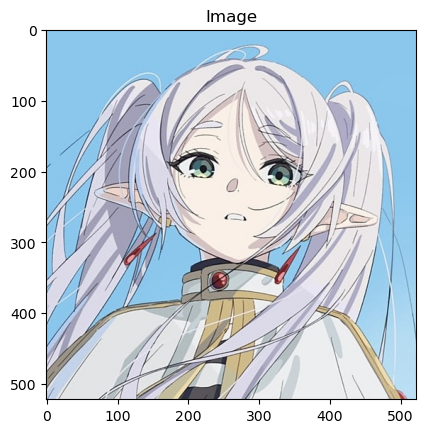

In [55]:
path = urlopen(r'https://github.com/BaroqueObama/hhs-ws-quadtrees/blob/main/images/fr.jpg?raw=true')
display_image(path)

## Run Quadtree Splits

In [56]:
def make_art(iterations, path, title="Rendered Image", frame_num=[-1, 0, 1, 2, 3, 4, 5, 6, 8, 9, 11, 13, 15, 17, 22, 28, 36, 46, 58, 74, 95, 121, 153, 195, 248, 316, 401, 510, 649, 825, 1049, 1333, 1694, 2154, 2738, 3480, 4424, 5623, 7147, 9085, 11547, 14677, 18656, 23713, 30141, 38311, 48696, 61896, 78674, 99999]):
    # Read in image
    frames = []
    arr = np.asarray(bytearray(path.read()), dtype=np.uint8)
    image = cv2.imdecode(arr, -1)
    color = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    render = image.copy()
    # Instantiate first Quad
    canvas = Quad(image, render, 0, image.shape[0], 0, image.shape[1])
    
    color = cv2.cvtColor(canvas.render, cv2.COLOR_BGR2RGB)
    plt.imshow(color)
    plt.savefig(f'gif_img/img_{-1}.png', transparent = False)
    image = imageio.v2.imread(f'gif_img/img_{-1}.png')
    frames.append(image)
    plt.show()
    
    for i in range(iterations):
        canvas.split()
        # Rendering
        clear_output(wait = True)
        color = cv2.cvtColor(render, cv2.COLOR_BGR2RGB)
        plt.imshow(color)
        plt.title(title)
        if i in frame_num:
            # GIF Saving
            plt.savefig(f'gif_img/img_{i}.png', transparent = False)
            image = imageio.v2.imread(f'gif_img/img_{i}.png')
            frames.append(image)
        plt.show()
    return frames
        

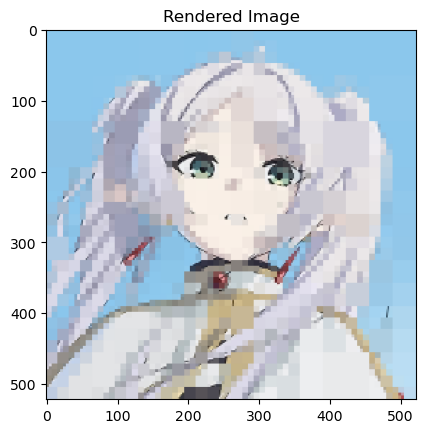

In [59]:
path = urlopen(r'https://github.com/BaroqueObama/hhs-ws-quadtrees/blob/main/images/fr.jpg?raw=true')
frames = make_art(1050, path)

## Make GIF

In [ ]:
def make_gif(frames=None, iterations=None, fps=5, name="test.gif", frame_num=[-1, 0, 1, 2, 3, 4, 5, 6, 8, 9, 11, 13, 15, 17, 22, 28, 36, 46, 58, 74, 95, 121, 153, 195, 248, 316, 401, 510, 649, 825, 1049, 1333, 1694, 2154, 2738, 3480, 4424, 5623, 7147, 9085, 11547, 14677, 18656, 23713, 30141, 38311, 48696, 61896, 78674, 99999]):
    if not frames == None:
        imageio.mimsave(name, frames, fps=fps)
    elif not iterations == None:
        frames = []
        for frame in frame_num:
            if frame >= iterations:
                break
            else:
                image = imageio.v2.imread(f'gif_img/img_{frame}.png')
                frames.append(image)
        imageio.mimsave(name, frames, fps=fps)

In [ ]:
make_gif(frames=frames, name="gifs/frieren1000.gif")

![](gifs/frieren1000.gif)

## Examples

### Mr. Shelby

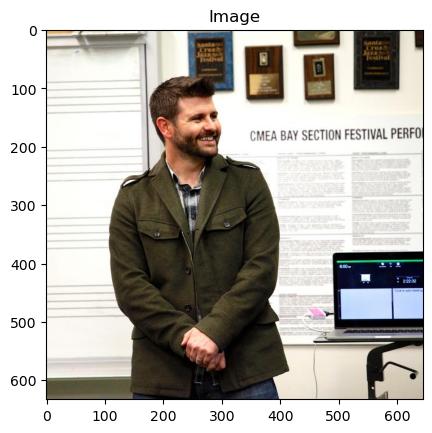

In [58]:
path = urlopen(r"https://www.mercurynews.com/wp-content/uploads/2016/08/20150429__ssvs0501toty2.jpg?")
display_image(path)

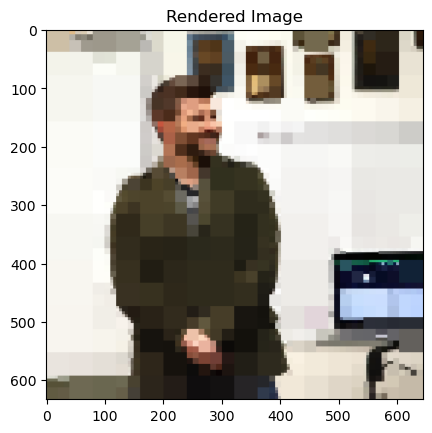

In [ ]:
path = urlopen(r"https://www.mercurynews.com/wp-content/uploads/2016/08/20150429__ssvs0501toty2.jpg?")
frames = make_art(511, path)
make_gif(frames=frames, name="gifs/shelby.gif")

![](gifs/shelby.gif)

### Obama

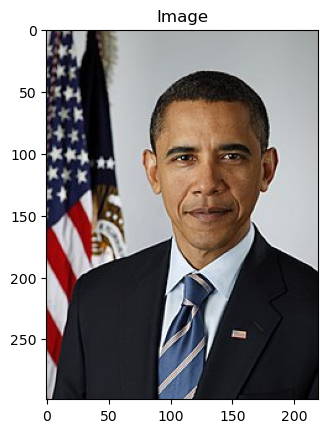

In [60]:
path = urlopen(r"https://upload.wikimedia.org/wikipedia/commons/thumb/e/e9/Official_portrait_of_Barack_Obama.jpg/220px-Official_portrait_of_Barack_Obama.jpg")
display_image(path)

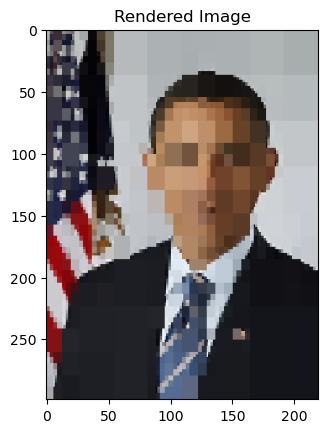

In [62]:
path = urlopen(r"https://upload.wikimedia.org/wikipedia/commons/thumb/e/e9/Official_portrait_of_Barack_Obama.jpg/220px-Official_portrait_of_Barack_Obama.jpg")
frames = make_art(511, path)
make_gif(frames=frames, name="gifs/obama.gif")

![](gifs/obama.gif)

### Alpaca

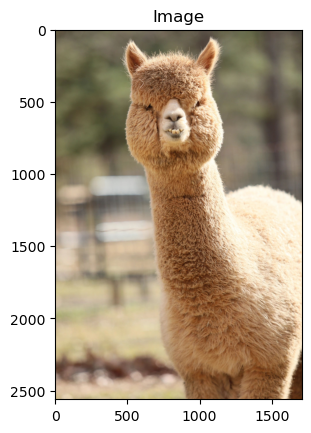

In [63]:
path = urlopen(r"https://img1.wsimg.com/isteam/ip/da624b94-4459-4959-bf8d-1abcae1905d2/Herd_It_Here_Photos_AEP%20(247)-0001.JPG")
display_image(path)

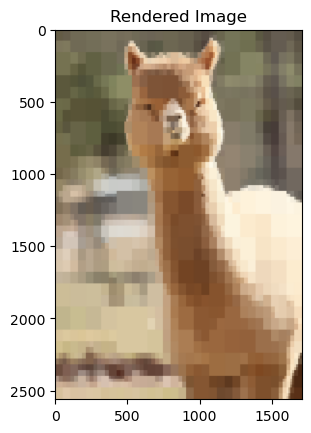

In [64]:
path = urlopen(r"https://img1.wsimg.com/isteam/ip/da624b94-4459-4959-bf8d-1abcae1905d2/Herd_It_Here_Photos_AEP%20(247)-0001.JPG")
frames = make_art(511, path)
make_gif(frames=frames, name="gifs/alpaca.gif")

![](gifs/alpaca.gif)

### Zebra

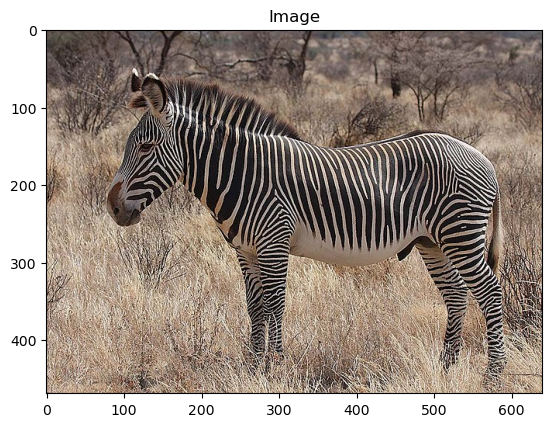

In [65]:
path = urlopen(r"https://upload.wikimedia.org/wikipedia/commons/thumb/7/74/Grevy%27s_Zebra_Stallion.jpg/640px-Grevy%27s_Zebra_Stallion.jpg")
display_image(path)

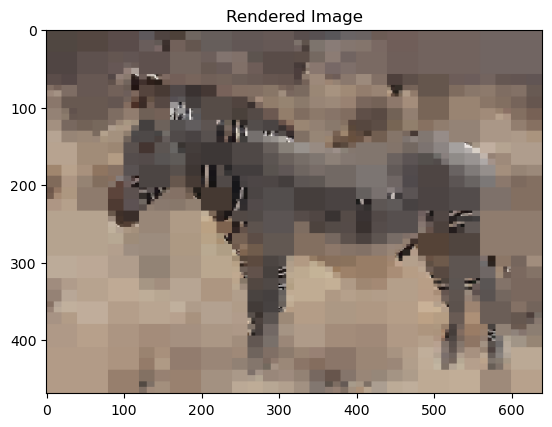

In [68]:
path = urlopen(r"https://upload.wikimedia.org/wikipedia/commons/thumb/7/74/Grevy%27s_Zebra_Stallion.jpg/640px-Grevy%27s_Zebra_Stallion.jpg")
frames = make_art(511, path)
make_gif(frames=frames, name="gifs/zebra.gif")

![](gifs/zebra.gif)

### XKCD Comic

libpng warning: iCCP: known incorrect sRGB profile


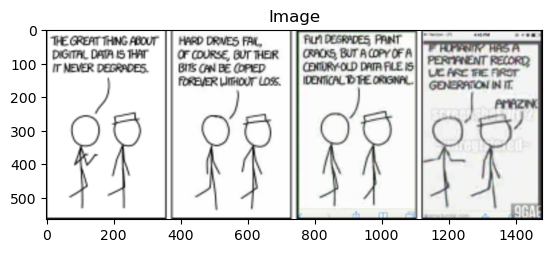

In [70]:
path = urlopen(r"https://imgs.xkcd.com/comics/digital_data_2x.png")
display_image(path)

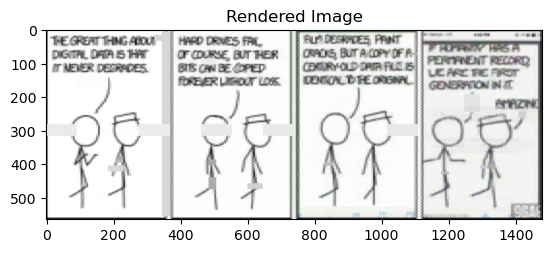

In [72]:
path = urlopen(r"https://imgs.xkcd.com/comics/digital_data_2x.png")
frames = make_art(11548, path)
make_gif(frames=frames, name="gifs/xkcd.gif")

![](gifs/xkcd.gif)